# Benchmark ComBind on PDB ligands

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from benchmark import benchmark, load_pdb, ligand_level_performance

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = load_pdb('/Users/jpaggi/Downloads/combind_data/bpp_outputs/stats6_pdb.tsv')

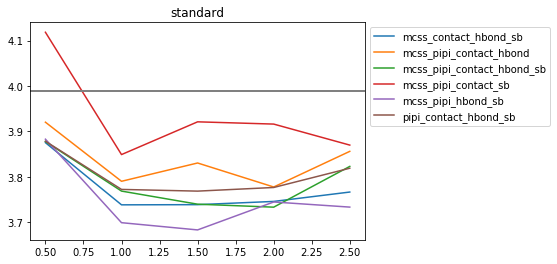

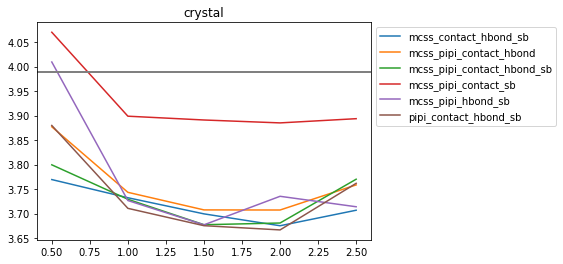

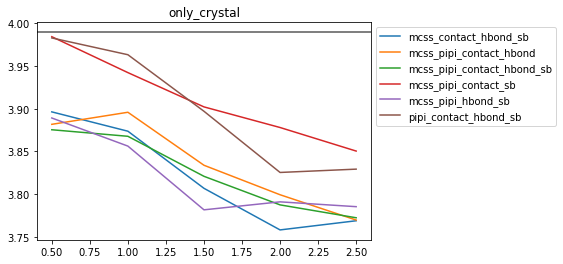

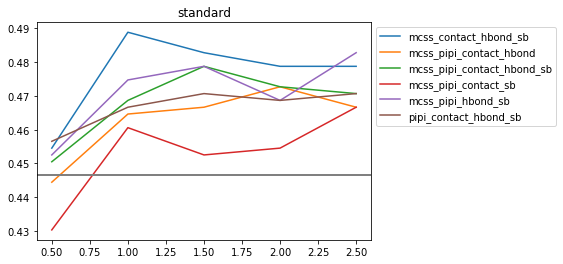

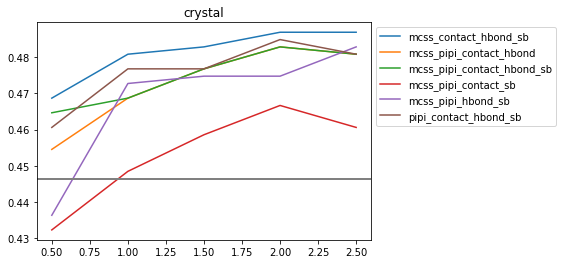

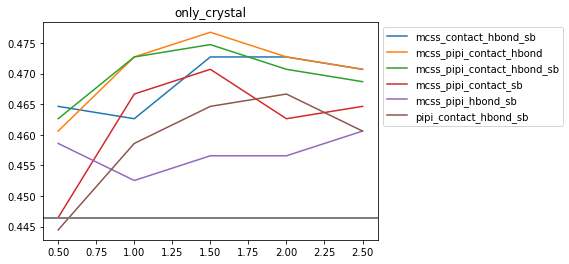

In [3]:
def sweep(data, mode, thresh = None):
    def metric(x):
        if thresh is None:
            return np.mean(x)
        return np.mean(np.array(x) <= thresh)
    
    alpha_factors = sorted(set(k[0] for k in data[mode].keys()))
    features = sorted(set(k[1] for k in data[mode].keys()))
    for feature in features:
        performances = []
        for alpha_factor in alpha_factors:
            performances += [ligand_level_performance(data[mode][(alpha_factor, feature)])]
        plt.plot(alpha_factors, [metric(p[1]) for p in performances], label = feature)
        for p in performances:
            plt.axhline(metric(p[0]), c = 'grey')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(mode)
    plt.show()

sweep(data, 'standard')
sweep(data, 'crystal')
sweep(data, 'only_crystal')

thresh = 2.0
sweep(data, 'standard', thresh)
sweep(data, 'crystal', thresh)
sweep(data, 'only_crystal', thresh)

495 valid ligands
Ttest_relResult(statistic=3.2168222766704515, pvalue=0.0013812127124495353)
ComBind improves pose for 89 of 495 ligands
ComBind degrades pose for 49 of 495 ligands
All Ligands RMSD Glide: 3.98933663778, 0.446464646465
All Ligands RMSD ComBind: 3.73799290217, 0.488888888889


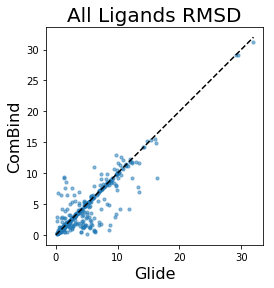

Mean RMSD Glide: 4.03164181764
Mean RMSD ComBind: 3.67774447578


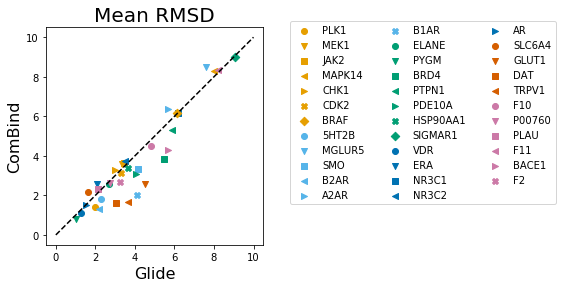

Fraction Near-Native Glide: 0.433611185733
Fraction Near-Native ComBind: 0.514810847416


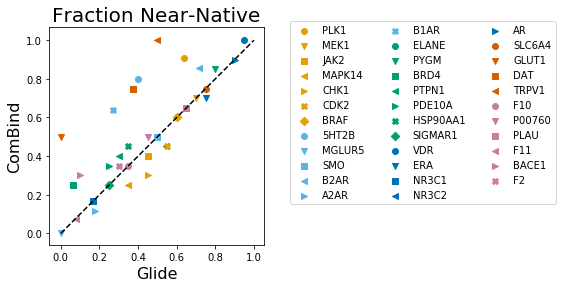

In [4]:
benchmark(data['standard'][(1.0, 'mcss_contact_hbond_sb')])

In [5]:
from benchmark import get_mcss_sizes
mcss_sizes = get_mcss_sizes(data['standard'][(1.0, 'mcss_contact_hbond_sb')])

ELANE
VDR
5HT2B
SLC6A4
PLK1
MGLUR5
ERA
F10
GLUT1
SMO
DAT
MEK1
JAK2
TRPV1
PYGM
P00760
MAPK14
B2AR
NR3C1
NR3C2
PLAU
AR
BRD4
PTPN1
F11
PDE10A
A2AR
BACE1
F2
CHK1
CDK2
BRAF
HSP90AA1
B1AR
SIGMAR1


184 valid ligands
Ttest_relResult(statistic=2.9957081728913115, pvalue=0.003117572938171055)
ComBind improves pose for 33 of 184 ligands
ComBind degrades pose for 12 of 184 ligands
All Ligands RMSD Glide: 2.9431525392, 0.565217391304
All Ligands RMSD ComBind: 2.63386209433, 0.657608695652


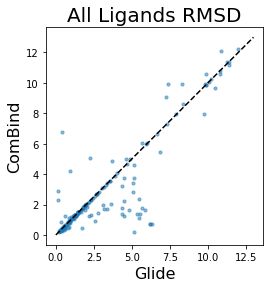

Mean RMSD Glide: 2.76308113307
Mean RMSD ComBind: 2.40856710644


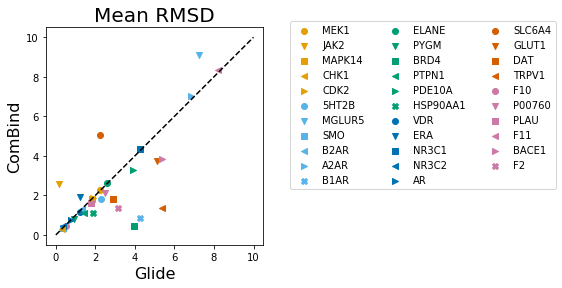

Fraction Near-Native Glide: 0.551392826407
Fraction Near-Native ComBind: 0.65940665694


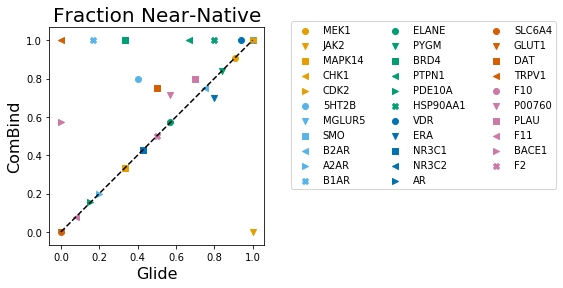

In [33]:
benchmark(data['standard'][(1.0, 'mcss_contact_hbond_sb')], mcss_sizes = mcss_sizes, low = 0.5)